# Group 5: Movie Recommender Challenge: Unsupervised Learning - EDSA

### Drikus Notebook 

![title](resources/imgs/Recommend.png)

## Table of Contents

1. <a href ="#1.-Challenge-Description">Challenge Description</a>
2. <a href ="#2.-Evaluation-Metric">Evaluation Metric</a>
3. <a href ="#3.-Comet-Experiment">Comet Experiment</a>
4. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
5. <a href ="#5.-Importing-Data">Importing Data</a>
6. <a href ="#6.-Data-Description">Data Decription</a>
7. <a href ="#7.-Exploratory-Data-Analysis"> Exploratory Data Analysis</a>
8. <a href ="#8.-Recommendation-System:-Content-Based-Filtering">Recommendation System: Content Based Filtering</a>
9. <a href ="#9.-Dimensionality-Reduction">Dimensionality Reduction</a>
10. <a href ="#10.-Collaborative-Filtering">Collaborative Filtering</a>
11. <a href ="#11.-Conclusion">Conclusion</a>
12. <a href ="#12.-Submission">Submission</a>


## 1. Challenge Description

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging US to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## 2. Evaluation Metric

The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

![RMSE.PNG](resources/imgs/RMSE.png)


Where R is the total number of recommendations generated for users and movies, with r_{ui} and r-hat_{ui} being the true, and predicted ratings for user u watching movie i, respectively.

## 3. Comet Experiment 

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="1DpubPFI6szNQR3Dou0CiLiDC",
    project_name="recommender",
    workspace="drikus-d",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/drikus-d/recommender/e413252ed1624c4c9346dec4cdc1b9b9



## 4. Importing Libraries

Import supporting python libraries to help construct our recommendation model.

In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Packages for Randomisation
import random

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 5. Importing Data

In [3]:
import os
os.chdir('C:/Users/Drikus/OneDrive/Documents/EXPLORE Coursework/Unsupervised/PredictData')

#C:\Users\Drikus\OneDrive\Documents\EXPLORE Coursework\Unsupervised\PredictData

In [4]:
movies_df = pd.read_csv('./movies.csv') 
imdb_df = pd.read_csv('./imdb_data.csv')
genome_score = pd.read_csv('./genome_scores.csv')
genome_tags = pd.read_csv('./genome_tags.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
tags_df = pd.read_csv('./tags.csv')
links_df = pd.read_csv('./links.csv')
sample_submission_df = pd.read_csv('./sample_submission.csv') 

#### The aim of the Kaggle competition is to determine the rating score for the respective movieId. 

#### Understanding the Submision Format (as per imported sample_submission file)
For every author in the dataset, submission files should contain two columns: Id and rating. 'Id' is a concatenation of the userID and movieID given in the test file. 'rating' is the predicted rating for a given user-movie pair.

In [5]:
sample_submission_df.head(3)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0


## 6. Data Description & Summary Statistics

### Train and test data 

In [6]:
# View train data info, shape and content  
display(train_df.head(3))
display(train_df.info()) # Get the summary of the dataset's metadata
print(train_df.isnull().sum()) # check if there are any null values)

# View test data info, shape and content  
display(test_df.head(3))
display(test_df.info()) # Get the summary of the dataset's metadata
print(test_df.isnull().sum()) # check if there are any null values)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


None

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId
0,1,2011
1,1,4144
2,1,5767


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


None

userId     0
movieId    0
dtype: int64


All of the data to train our model and in test data has numerical data types, great for unsupervised learning.  <br>
1 000 0038 observations in train, 5 000 019 in test<br>
There are no null values in the test or train dataset <br>

### Movies data 

In [7]:
# View movies data info and shape and content head 
display(movies_df.head())
movies_df.info() # Get the summary of the dataset's metadata
print(movies_df.isnull().sum()) # check if there are any null values)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
movieId    0
title      0
genres     0
dtype: int64


Movies dataset: numerical data types, 62423 observations, no null values in the dataset <br>
Movie dataset contains extra movie info such as the title and genre 

### Genome Scores and tags 

The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

In [8]:
genome_tags.info() # Summary of the Genome_tag Dataframe 
genome_score.info() # Summary of the Genome_score Dataframe 
display(genome_tags.head()) # Tags - what do they discribe? 
print(genome_tags.isnull().sum())
print(genome_tags.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


tagId    0
tag      0
dtype: int64
tagId    0
tag      0
dtype: int64


More than 15 million genome scores make up the genome_score data set  <br>1128 observations in the genome tags dataframe. These datasets gives us the tags and their relative score. <br>The genome tag df consists of the tagId as well the tag which is a string<br>
No null values in either tags or score

### Imdb database of movies

Additional movie content data obtained from [IMDB](https://www.imdb.com/)

In [9]:
display(imdb_df.head()) 
display(imdb_df.info()) # Summary of imdb database
print(imdb_df.isnull().sum())

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


None

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


Note there are 62423 movies in the movies database and only 27278 in the imdb dataset <br>
The IMBD dataset gives more infomation to about 27000+ movies present in the train dataset. The features are title_cast, director, runtime, budget as well plot_keywords. The title_cast feature describes the most famous/paid actors/actresses in the movie and runtime describes how long movie was and plot_keyword describes the most important key words of the plot

## 7. Exploratory Data Analysis

We investigate through EDA four areas to get insights before we tackle modelling:  

* **Rating Analysis**
* **User Analysis**
* **Year Analysis**
* **Genre Analysis**


### Ratings 
The train dataset gives an overview of how each user rated each movie. What was observed that each user can rate a movie from 0.5 (Worst) to 5.0 (Best). Here is the full detailed scale:
 * 0.5 - Very Bad
 * 1.0 - Bad
 * 1.5 - Moderately Bad
 * 2.0 - Not that Bad
 * 2.5 - Less than average 
 * 3.0 - Average 
 * 3.5 - Above than average 
 * 4.0 - Good
 * 4.5 - Very Good
 * 5.0 - Excellent 
 <br>
 
**How many movies whererated there per rating category?**
    

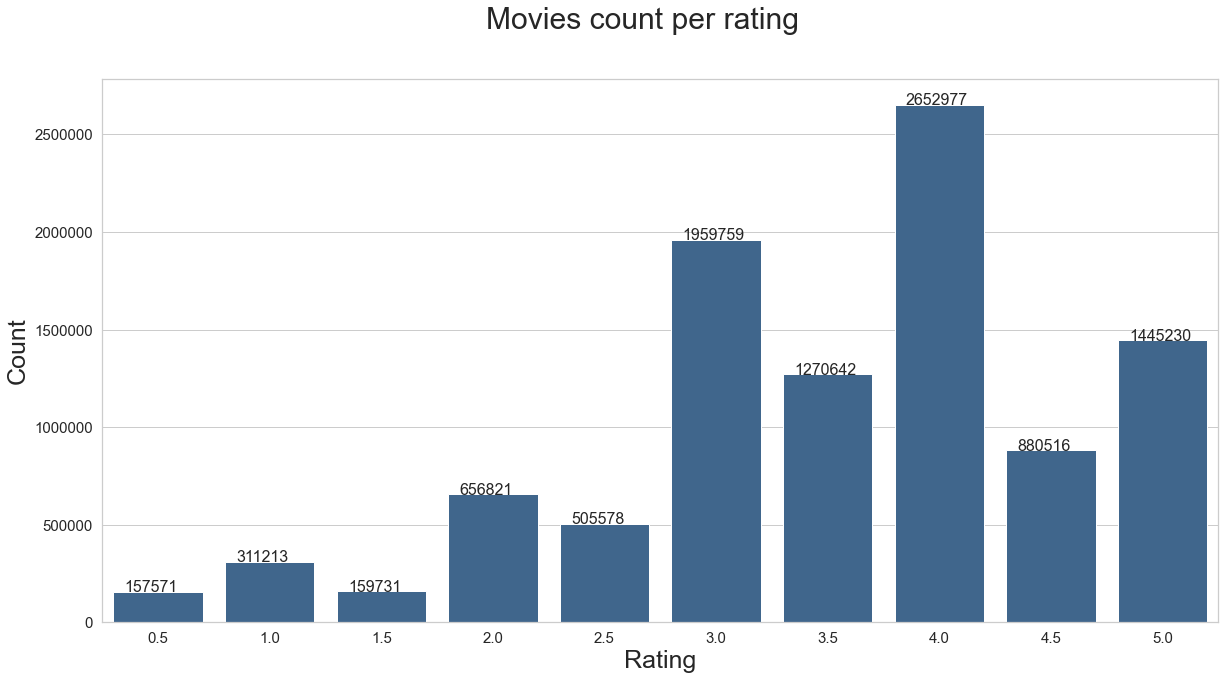

In [10]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

# Create a countplot to visualise the number of movies per category
sns.countplot(ax=ax, x='rating', data=train_df, color=(0.2, 0.4, 0.6, 0.6)) 
plt.xlabel('Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(size = 15)
plt.yticks(size = 15)
fig.suptitle("Movies count per rating", fontsize=30)
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the tick labels to appear in non-scientific form

# Make the counts appear on the different bars
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()), size = 16)
    
# Show the countplot
plt.show()

Most movies where scored with a rating of 4 <br><br>
**Is there a correlation between how many times movies where rated and the rating?**

## 8. Recommendation System: Content Based Filtering

## 9. Dimensionality Reduction

## 10. Collaborative Filtering

## 11. Conclusion

In [106]:
# End Comet Experiment 
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/drikus-d/recommender/1d28593c465c4bbab5fca4db05ff47df
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (10.65 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds t

## 12. Submission